In [1]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 
from sklearn.decomposition import PCA
from tqdm import tqdm

## Load Data

In [2]:
import seaborn as sns

In [3]:
data =  pd.read_csv('processed_data/train_norm_corr' , index_col = 0)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,class,src_n,src_id,significance,flux_aper_hilim_s,flux_aper_hilim_u,flux_aper_hilim_m,flux_aper_hilim_h,flux_aper_hilim_b,flux_aper_lolim_s,...,flux_brems,flux_brems_lolim,flux_brems_hilim,brems_kt,brems_kt_hilim,brems_kt_lolim,brems_nh,brems_nh_hilim,brems_nh_lolim,brems_stat
0,NS,XMMU J004245.2+41172,NS0046,4.71,0.438294,0.574176,0.414312,0.542621,0.531771,0.425335,...,0.649066,0.670572,0.641180,0.793388,0.100719,1.124712,0.765197,0.718556,0.833528,0.791033
1,BH,J1745-2900,BH0027,337.00,0.375715,0.729569,0.456404,0.736890,0.727390,0.368862,...,0.081592,0.087508,0.078716,0.977862,0.121373,1.400523,1.111106,1.043694,1.209083,0.761531
2,NS,XMMU J004245.2+41172,NS0044,49.26,0.719010,0.620138,0.659644,0.700960,0.720418,0.733832,...,0.064270,0.069710,0.061547,0.677741,0.087770,0.951805,0.660320,0.619977,0.719663,0.905748
3,NS,1WGA J0748.5-6745,NS0076,6.77,0.365754,0.265484,0.261819,0.300147,0.340543,0.287778,...,0.039628,0.044391,0.037123,0.596777,0.078705,0.830754,0.678153,0.636740,0.739025,0.701765
4,BH,SAXWFC J1819.4-2524.,BH0030,2.24,0.148567,0.072308,0.224580,0.137748,0.097742,0.163878,...,0.473499,0.490182,0.467163,0.331771,0.049034,0.434538,1.111106,1.043694,1.209083,0.643094


In [4]:
info_col = [ 'class' , 'src_n' , 'src_id' , 'significance']
data_info = data[info_col]
data_val = data.drop(columns=info_col) 
data_label = data['class']

In [5]:
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestClassifier 
clf = RandomForestClassifier()

# PCA

### Acc Function

In [5]:
def acc_df(train_scores , valid_scores , param_range, n_dim):
    df = pd.DataFrame(train_scores)
    df.insert(0 , 'num_trees' , param_range)
    df = df.set_index('num_trees')
    df_train = df.stack().reset_index().drop(columns=['level_1']).set_index('num_trees')
    df_train.columns = ['acc_val']
    df_train.insert(1 , 'acc_type' , ['train_acc']*len(df_train))
    df_train.insert(0 , 'n_dim' , [n_dim]*len(df_train))
    df_train

    df = pd.DataFrame(valid_scores)
    df.insert(0 , 'num_trees' , param_range)
    df = df.set_index('num_trees')
    df_test = df.stack().reset_index().drop(columns=['level_1']).set_index('num_trees')
    df_test.columns = ['acc_val']
    df_test.insert(1 , 'acc_type' , ['test_acc']*len(df_test))
    df_test.insert(0 , 'n_dim' , [n_dim]*len(df_test))
    df_test
    acc = pd.concat([df_train , df_test] , axis=0).reset_index()
    return acc

In [6]:
def pca_wrap(param_name , param_range , n_dim = 10 , ):
    np.random.seed(29832)
    indices = np.arange(data_label.shape[0])
    if(n_dim < data_val.shape[1]):
        data_pca = PCA(n_components=n_dim , whiten=True ).fit_transform(data_val)
    else : data_pca = data_val.copy().values
    X, y = data_pca[indices], data_label.iloc[indices]
    train_scores, valid_scores = validation_curve(clf, X, y, param_name=param_name, param_range=param_range,cv=5)
    acc = acc_df(train_scores , valid_scores, param_range , n_dim)
    return acc


In [671]:
n_tree_range=np.arange(1,500 , 100)
n_dim_range = np.linspace(1.1,1.325 , num=16)**16
n_dim_range = [int(ti) for ti in n_dim_range ]
n_dim_range= np.append(n_dim_range[:-1],92)
print(n_dim_range[:])
print(n_tree_range[:])
acc = []
for pi in tqdm(n_dim_range):
    acc.append(pca_wrap('n_estimators' , n_tree_range , pi)) 



[ 4  5  7  8 10 13 16 19 24 29 35 42 51 62 75 92]
[  1 101 201 301 401]


100%|██████████| 16/16 [03:35<00:00, 13.49s/it]


In [672]:
acc_all = pd.concat(acc).reset_index(drop=True)
acc_all

,num_trees,n_dim,acc_val,acc_type
0,1,4,0.942935,train_acc
1,1,4,0.934783,train_acc
2,1,4,0.929348,train_acc
3,1,4,0.910326,train_acc
4,1,4,0.891304,train_acc
...,...,...,...,...
795,401,92,0.858696,test_acc
796,401,92,0.869565,test_acc
797,401,92,0.880435,test_acc
798,401,92,0.923913,test_acc


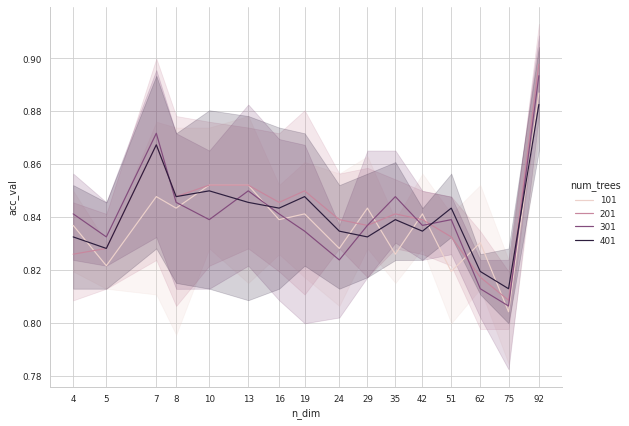

In [673]:
sns.set_theme('paper')
sns.set_style('whitegrid')
colors = sns.color_palette('mako' ,n_colors=4)
to_plot = acc_all[acc_all['acc_type']=='test_acc']
to_plot = to_plot[to_plot['num_trees']>10]
acc_plot = sns.relplot(
    data = to_plot , kind='line' , 
    x = 'n_dim' , y = 'acc_val' , 
    hue = 'num_trees' ,
    height = 6 , aspect = 8/6,
    color = 'black' ,
    #alpha=0.1
    #palette='bright'
)
acc_plot.set(xscale='log')
#acc_plot.set(yscale='log')
acc_plot.set(xticks=n_dim_range)
acc_plot.set(xticklabels=n_dim_range)
plt.show()

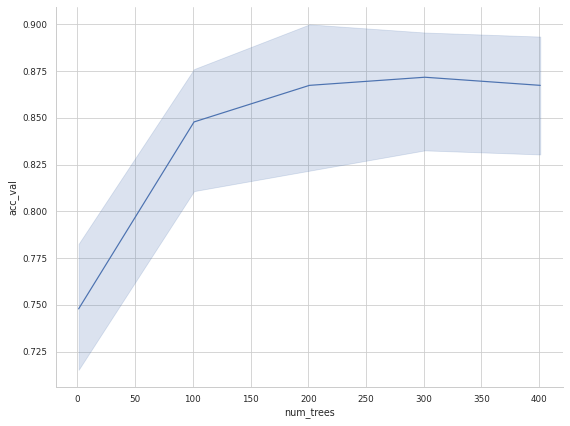

In [677]:
sns.set_theme('paper')
sns.set_style('whitegrid')
palette = sns.color_palette("mako_r", 4)
to_plot = acc_all[acc_all['acc_type']=='test_acc']
to_plot = to_plot[to_plot['n_dim']==7]
acc_plot = sns.relplot(
    data = to_plot , kind='line' , 
    x = 'num_trees' , y = 'acc_val' , 
    #hue = 'num_trees' ,
    height = 6 , aspect = 8/6,
    palette='copper'
)
#acc_plot.set(xscale='log')
#acc_plot.set(yscale='log')
#acc_plot.set(xticks=n_dim_range)
#acc_plot.set(xticklabels=n_dim_range)
plt.show()

# Hyper Parameter Tuning

In [511]:
rfc_v2 = RandomForestClassifier()

## Random Search

In [512]:
from sklearn.model_selection import RandomizedSearchCV

In [513]:
n_estimators = [int(x) for x in np.linspace(80 , 500 , num=12)]
max_features = ['log2' , 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 100, num = 15)]
min_samples_split = [int(x) for x in np.linspace(2,50 ,10)]
min_samples_leaf = [int(x) for x in np.linspace(2,50 , 10)]
bootstrap = [True , False]

In [514]:
params_dict = {
    'n_estimators' : n_estimators , 
    'max_features' : max_features ,
    'max_depth' :max_depth , 
    'min_samples_split' : min_samples_split , 
    'min_samples_leaf' : min_samples_leaf, 
    'bootstrap' : bootstrap 
}

In [515]:
rs = RandomizedSearchCV(
    rfc_v2 , 
    params_dict , 
    n_iter = 100 ,
    cv = 5 ,
    verbose=5 ,
    n_jobs=-1 , 
    random_state= 0 
)

In [516]:
rs.fit(data_val , data_label)
rs.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'n_estimators': 156,
 'min_samples_split': 18,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 100,
 'bootstrap': False}

In [518]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,split3_test_score,split4_test_score,mean_test_score,rank_test_score
0,156,18,2,sqrt,100,False,0.902174,0.826087,0.891304,1
1,423,12,7,sqrt,71,False,0.880435,0.804348,0.880435,2
2,194,28,2,log2,29,False,0.891304,0.804348,0.878261,3
3,194,44,12,sqrt,43,False,0.880435,0.804348,0.876087,4
4,309,7,2,log2,8,True,0.902174,0.804348,0.873913,5
5,500,44,7,sqrt,92,False,0.880435,0.793478,0.869565,6
6,347,39,7,sqrt,43,False,0.902174,0.782609,0.869565,6
7,347,50,12,sqrt,92,False,0.869565,0.793478,0.867391,8
8,461,2,18,sqrt,71,False,0.858696,0.793478,0.865217,9
9,309,28,7,log2,43,False,0.902174,0.782609,0.865217,9


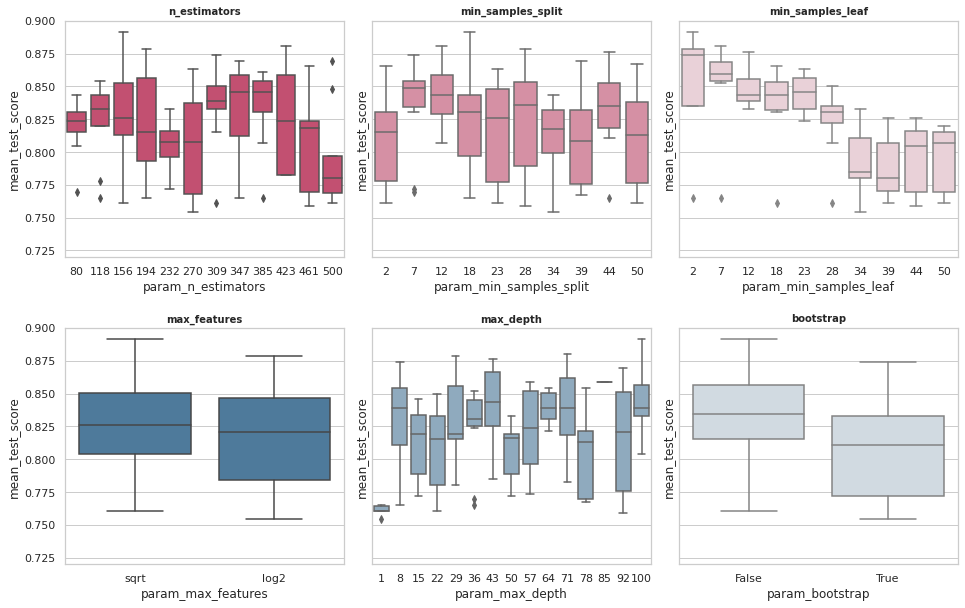

In [667]:
sns.set(style="whitegrid", color_codes=True, font_scale = 1)
fig, axs = plt.subplots(ncols=3, nrows=2  , sharey=True)
fig.set_size_inches(16,10)
colors = sns.diverging_palette(240, 0, n=6 , )
sns.boxplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0],color=colors[5]) 
axs[0,0].set_ylim([.72,.90])
axs[0,0].set_title(label = 'n_estimators', size=10, weight='bold')
sns.boxplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1],color=colors[4])
#axs[0,1].set_ylim([.85,.93])
axs[0,1].set_title(label = 'min_samples_split', size=10, weight='bold')
sns.boxplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2],color=colors[3])
#axs[0,2].set_ylim([.80,.93])
axs[0,2].set_title(label = 'min_samples_leaf', size=10, weight='bold')
sns.boxplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0],color=colors[0])
#axs[1,0].set_ylim([.88,.92])
axs[1,0].set_title(label = 'max_features', size=10, weight='bold')
sns.boxplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1],color=colors[1])
#axs[1,1].set_ylim([.80,.93])
axs[1,1].set_title(label = 'max_depth', size=10, weight='bold')
sns.boxplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2] , color=colors[2])
#axs[1,2].set_ylim([.88,.92])
axs[1,2].set_title(label = 'bootstrap', size=10, weight='bold')
fig.subplots_adjust(wspace=0.1 , hspace=0.3)

plt.show()


### Result
> Best Model Parameters
```
{'n_estimators': 423,
 'min_samples_split': 12,
 'min_samples_leaf': 7,
 'max_features': 'sqrt',
 'max_depth': 71,
 'bootstrap': False}
```
> Best Parameter values

```
{'n_estimators': [309 , 347,385],
 'min_samples_split': [7,12,44],
 'min_samples_leaf': [2,7,12],
 'max_features': 'sqrt',
 'max_depth': [43 ,85, 100],
 'bootstrap': False}
```

## Grid Search

In [1]:
from sklearn.model_selection import GridSearchCV

In [520]:
n_estimators = [309 , 347,385]
max_features = ['sqrt'] 
bootstrap = [False]
max_depth =  [43 ,85, 100]
min_samples_leaf = [2,7,12]
min_samples_split = [7,12,44]

In [522]:
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [523]:
gs = GridSearchCV(rfc_v2 , param_grid , cv=5 , verbose=5 , n_jobs=-1)
gs.fit(data_val , data_label)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [43, 85, 100],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [2, 7, 12],
                         'min_samples_split': [7, 12, 44],
                         'n_estimators': [309, 347, 385]},
             verbose=5)

In [524]:
gs.best_params_

{'bootstrap': False,
 'max_depth': 85,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 7,
 'n_estimators': 385}

# Comparison

### Train-test split

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as cf 
from sklearn.ensemble import RandomForestClassifier

In [7]:
data =  pd.read_csv('processed_data/train_norm_corr' , index_col = 0)
np.random.seed(433)
data = data.sample(frac=1).reset_index(drop=True)
split = int(0.8*(len(data)))
info_col = [ 'class' , 'src_n' , 'src_id' , 'significance']
data_info = data[info_col]
data_val = data.drop(columns=info_col) 
data_label = data['class']
x = data_val.copy()
y = data_label.copy()
x_train, x_test , y_train , y_test = x_train , x_test , y_train , y_test = train_test_split(x,y , test_size=0.2 , stratify=y)

### Monte Carlo Cross Validation 

In [8]:
from tqdm import tqdm
from sklearn.model_selection import train_test_split
def mc_validation(model_func , x  , y , model_name = '' , pca=False):
    train_acc = []
    test_acc = []

    for i in tqdm(range(32)):
        x_train , x_test , y_train , y_test = train_test_split(x,y , test_size=0.2 , stratify=y)
        if(pca):
            pca = PCA(n_components=7)
            x_train = pca.fit_transform(x_train)
            x_test = pca.transform(x_test)
        clf = model_func
        clf.fit(x_train , y_train)
        #print('train , test' , y_train.shape , y_test.shape)
        #print(clf.score(x_test, y_test))
        test_acc.append(clf.score(x_test , y_test))
        train_acc.append(clf.score(x_train , y_train))

    acc_train =  pd.DataFrame()
    acc_test = pd.DataFrame()

    
    acc_test.insert(0 , 'acc_type' , ['Test_acc']*len(train_acc))
    acc_test.insert(1 , 'accuracy' , test_acc)
    acc_test = acc_test.reset_index(drop=True)
   
    acc_train.insert(0 , 'acc_type' , ['Train_acc']*len(train_acc))
    acc_train.insert(1 , 'accuracy' , train_acc)
    acc_train = acc_train.reset_index(drop=True)

    acc = pd.concat([acc_train , acc_test]).reset_index(drop=True)
    acc.insert(0 , 'model' , [model_name]*len(acc))
    return acc


## Vanilla RF

In [9]:
rf_vanila = RandomForestClassifier(n_estimators=300)
rf_vanila.fit(x_train , y_train)
y_pred_vanila = rf_vanila.predict(x_test)
cf_vanila = cf(y_test , y_pred_vanila)
print(cf_vanila) 

[[25  7]
 [ 6 54]]


In [10]:
rf_vanila.score(x_test, y_test)

0.8586956521739131

In [11]:
print(y_train.shape , y_test.shape)

(368,) (92,)


In [12]:
acc_vanila = mc_validation(rf_vanila , data_val , data_label, model_name='Vanila_RF').reset_index(drop=True)
acc_vanila

100%|██████████| 32/32 [00:34<00:00,  1.08s/it]


,model,acc_type,accuracy
0,Vanila_RF,Train_acc,1.000000
1,Vanila_RF,Train_acc,1.000000
2,Vanila_RF,Train_acc,1.000000
3,Vanila_RF,Train_acc,1.000000
4,Vanila_RF,Train_acc,1.000000
...,...,...,...
59,Vanila_RF,Test_acc,0.858696
60,Vanila_RF,Test_acc,0.923913
61,Vanila_RF,Test_acc,0.891304
62,Vanila_RF,Test_acc,0.847826


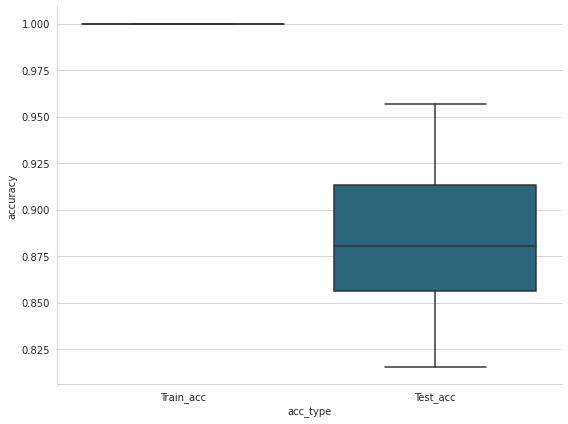

In [14]:
sns.set_style('whitegrid')
sns.catplot(data = acc_vanila , y='accuracy' , x = 'acc_type' ,
            #hue= 'acc_type'  , 
            kind='box' ,  
            palette = 'crest' , height=6 , aspect=8/6
            )
#plt.savefig('result/model_var_rf.jpg')
plt.show()

## Vanilla RF with PCA

In [20]:
from sklearn.decomposition import PCA

In [21]:
pca = PCA(n_components=7 ,svd_solver='full' , random_state=2)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

rf_van_pca = RandomForestClassifier(n_estimators=300)
rf_van_pca.fit(x_train_pca , y_train)
y_pred_van_pca = rf_van_pca.predict(x_test_pca)
cf_van_pca = cf(y_test , y_pred_van_pca)
print(cf_van_pca) 

[[27  5]
 [ 7 53]]


In [22]:
acc_vanila_pca = mc_validation(rf_van_pca , data_val , data_label ,model_name = 'vanila_rf_PCA' ,  pca=True ,).reset_index(drop=True)
acc_vanila_pca

100%|██████████| 32/32 [00:25<00:00,  1.23it/s]


,model,acc_type,accuracy
0,vanila_rf_PCA,Train_acc,1.000000
1,vanila_rf_PCA,Train_acc,1.000000
2,vanila_rf_PCA,Train_acc,1.000000
3,vanila_rf_PCA,Train_acc,1.000000
4,vanila_rf_PCA,Train_acc,1.000000
...,...,...,...
59,vanila_rf_PCA,Test_acc,0.739130
60,vanila_rf_PCA,Test_acc,0.891304
61,vanila_rf_PCA,Test_acc,0.858696
62,vanila_rf_PCA,Test_acc,0.880435


## Tuned RF

In [23]:
rf_t = RandomForestClassifier(n_estimators=385 ,
        min_samples_split = 7 ,
        min_samples_leaf = 2 , 
        max_depth = 85 , 
        bootstrap=False , 
        max_features = 'sqrt',
        random_state=2
        )
rf_t.fit(x_train , y_train)


RandomForestClassifier(bootstrap=False, max_depth=85, max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=7,
                       n_estimators=385, random_state=2)

In [24]:

y_pred_t = rf_t.predict(x_test)
cf_t = cf(y_test , y_pred_t)
(cf_t)

array([[25,  7],
       [ 5, 55]])

In [25]:
acc_tuned = mc_validation(rf_t , data_val , data_label, model_name='Tuned_RF').reset_index(drop=True)
acc_tuned

100%|██████████| 32/32 [00:44<00:00,  1.40s/it]


,model,acc_type,accuracy
0,Tuned_RF,Train_acc,1.000000
1,Tuned_RF,Train_acc,1.000000
2,Tuned_RF,Train_acc,1.000000
3,Tuned_RF,Train_acc,1.000000
4,Tuned_RF,Train_acc,1.000000
...,...,...,...
59,Tuned_RF,Test_acc,0.880435
60,Tuned_RF,Test_acc,0.880435
61,Tuned_RF,Test_acc,0.891304
62,Tuned_RF,Test_acc,0.923913


## Result

In [28]:
acc = pd.concat([acc_vanila, acc_vanila_pca , acc_tuned]).reset_index(drop=True)

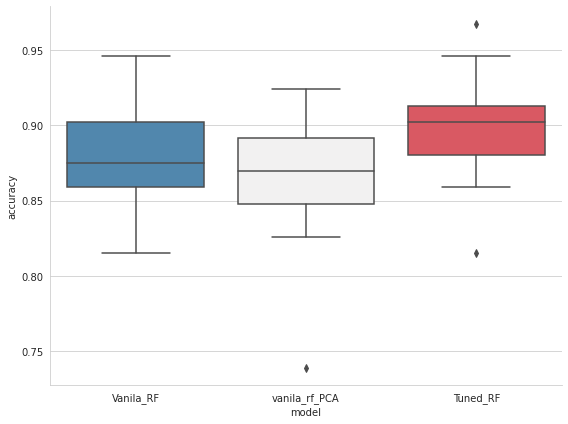

In [31]:
sns.set_style('whitegrid')
pal = sns.diverging_palette(240, 10, s=80, l=55, n=3)
sns.catplot(data = acc[acc['acc_type']=='Test_acc'] , y='accuracy' , x = 'model' ,
            kind='box' ,  # hue='acc_type',
            palette = pal , 
            height=6 , aspect=8/6
            )